In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
# Load DataFrame
df = pd.read_csv('FSFE_data.csv')

In [16]:
# Display DataFrame
df

,Mouth_Open_mean,Mouth_Open_std,Mouth_Open_skew,Mouth_Open_median,Mouth_Open_range,Mouth_Closed_mean,Mouth_Closed_std,Mouth_Closed_skew,Mouth_Closed_median,Mouth_Closed_range,...,Scared_skew,Scared_median,Scared_range,Disgusted_mean,Disgusted_std,Disgusted_skew,Disgusted_median,Disgusted_range,Artificiality,Expressiveness
0,0.001626,0.040292,24.740678,0.0,1,0.998374,0.040292,-24.740678,1.0,1,...,0.987182,0.042938,0.215839,0.017396,0.027293,1.762431,0.001511,0.149280,2,1
1,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,2.690334,0.025008,0.258095,0.001930,0.003207,6.252318,0.001025,0.064629,2,1
2,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,3.057499,0.001267,0.022736,0.020061,0.017527,4.511908,0.016444,0.238177,2,1
3,0.000055,0.007412,134.914788,0.0,1,0.999945,0.007412,-134.914788,1.0,1,...,6.393197,0.000325,0.026512,0.001943,0.005611,23.336876,0.001072,0.249527,2,1
4,0.001260,0.035469,28.125509,0.0,1,0.998740,0.035469,-28.125509,1.0,1,...,5.105870,0.000587,0.020964,0.007297,0.007052,5.976610,0.005617,0.144335,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.008999,0.094439,10.399382,0.0,1,0.991001,0.094439,-10.399382,1.0,1,...,5.848390,0.000865,0.025217,0.003897,0.004113,7.717646,0.003227,0.058343,1,2
76,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,1.966077,0.001292,0.009677,0.051939,0.035915,0.661456,0.046638,0.261266,1,2
77,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,2.964626,0.031134,0.203770,0.006393,0.004005,1.805111,0.005583,0.044648,1,2
78,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,1.710922,0.021423,0.165883,0.003480,0.002747,4.025735,0.002853,0.063627,1,2


In [17]:
# Extract features by dropping target columns from the DataFrame
X = df.drop(['Expressiveness','Artificiality'], axis=1)  
# Extract target variable 'Artificiality' from the DataFrame
y = df['Artificiality'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Initialize the pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=LogisticRegression(penalty='l2', random_state=42), step=1, cv=StratifiedKFold(5), scoring='f1')),
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=StratifiedKFold(10), scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters and feature set
grid_search_lr.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = grid_search_lr.best_params_
print("Best hyperparameters:", best_hyperparams)

# Extract the best pipeline with the optimal number of features and hyperparameters
best_pipeline_lr = grid_search_lr.best_estimator_

# Extract the number of features selected by RFECV
selected_features = best_pipeline_lr.named_steps['feature_selector'].n_features_
print(f"Number of features selected: {selected_features}")

# Make predictions using the best estimator returned by GridSearchCV
y_train_pred_lr = best_pipeline_lr.predict(X_train)
y_test_pred_lr = best_pipeline_lr.predict(X_test)

# Evaluation using the best estimator
f1_train_lr = f1_score(y_train, y_train_pred_lr, average='weighted')
f1_test_lr = f1_score(y_test, y_test_pred_lr, average='weighted')

# Output final F1 scores
print(f"F1 Score on training data: {f1_train_lr}")
print(f"F1 Score on test data: {f1_test_lr}")

# Output classification reports
print("Classification Report for Training Data (LR):")
print(classification_report(y_train, y_train_pred_lr))
print("Classification Report for Test Data (LR):")
print(classification_report(y_test, y_test_pred_lr))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best hyperparameters: {'classifier__C': 0.1, 'feature_selector__estimator__C': 0.1}
Number of features selected: 1
F1 Score on training data: 0.6652552926525529
F1 Score on test data: 0.5607843137254902
Classification Report for Training Data (LR):
              precision    recall  f1-score   support

           1       0.63      0.81      0.71        32
           2       0.74      0.53      0.62        32

    accuracy                           0.67        64
   macro avg       0.69      0.67      0.67        64
weighted avg       0.69      0.67      0.67        64

Classification Report for Test Data (LR):
              precision    recall  f1-score   support

           1       0.56      0.62      0.59         8
           2       0.57      0.50      0.53         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56      

          Feature  Coefficient
0  Surprised_skew     0.445085


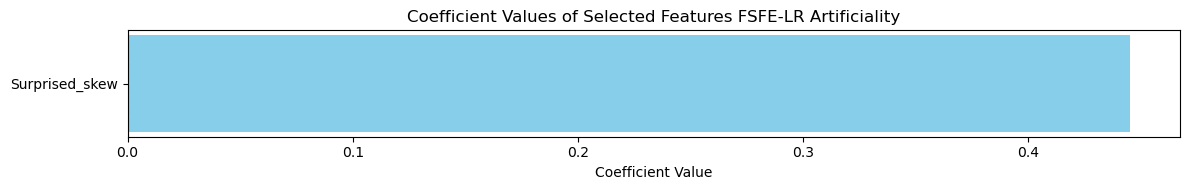

In [24]:
# Extract feature names
feature_names = X_train.columns

# Extract the boolean mask of selected features from RFECV
selected_features_mask_lr = best_pipeline_lr.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_lr = feature_names[selected_features_mask_lr]

# Extract the coefficients from the LR model
coefficients_lr = best_pipeline_lr.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_lr = pd.DataFrame({
    'Feature': selected_feature_names_lr,
    'Coefficient': coefficients_lr
})

# Sort the DataFrame by the absolute values of the coefficients for better readability
features_coefficients_df_lr = features_coefficients_df_lr.reindex(
    features_coefficients_df_lr.Coefficient.abs().sort_values(ascending=False).index
)

# Output the table
print(features_coefficients_df_lr)

# Save the DataFrame to a CSV file
features_coefficients_df_lr.to_csv('FSFE_Artificiality_Feature_Coefficients_LR.csv', index=False)

# Define colors based on the sign of the coefficients
colors = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_lr['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 2))
plt.barh(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Coefficient'],
    color=colors
)
plt.yticks(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FSFE-LR Artificiality')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

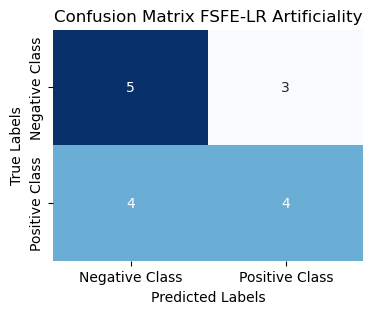

In [25]:
# Calculate the confusion matrix for the test data
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FSFE-LR Artificiality')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()

In [21]:
# Initialize the pipeline
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=SVC(kernel='linear'), step=1, cv=StratifiedKFold(5), scoring='f1')),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid_svc = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.1, 1, 10]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=StratifiedKFold(10), scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters and feature set
grid_search_svc.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams_svc = grid_search_svc.best_params_
print("Best hyperparameters for SVC:", best_hyperparams_svc)

# Extract the best pipeline with the optimal number of features and hyperparameters
best_pipeline_svc = grid_search_svc.best_estimator_

# Extract the number of features selected by RFECV
selected_features_svc = best_pipeline_svc.named_steps['feature_selector'].n_features_
print(f"Number of features selected for SVC: {selected_features_svc}")

# Make predictions using the best estimator returned by GridSearchCV
y_train_pred_svc = best_pipeline_svc.predict(X_train)
y_test_pred_svc = best_pipeline_svc.predict(X_test)

# Evaluation using the best estimator
f1_train_svc = f1_score(y_train, y_train_pred_svc, average='weighted')
f1_test_svc = f1_score(y_test, y_test_pred_svc, average='weighted')

# Output final F1 scores
print(f"F1 Score on training data: {f1_train_svc}")
print(f"F1 Score on test data: {f1_test_svc}")

# Output classification reports
print("Classification Report for Training Data (SVC):")
print(classification_report(y_train, y_train_pred_svc))
print("Classification Report for Test Data (SVC):")
print(classification_report(y_test, y_test_pred_svc))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


Best hyperparameters for SVC: {'classifier__C': 1, 'feature_selector__estimator__C': 1}
Number of features selected for SVC: 52
F1 Score on training data: 1.0
F1 Score on test data: 0.8117647058823529
Classification Report for Training Data (SVC):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Classification Report for Test Data (SVC):
              precision    recall  f1-score   support

           1       0.78      0.88      0.82         8
           2       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



                         Feature  Coefficient
11            Right Eye_Open_std     1.120529
14          Right Eye_Closed_std     1.120529
35                    Happy_mean     1.077347
18      Left Eyebrow_Raised_mean     0.910508
19       Left Eyebrow_Raised_std     0.895184
45                   Angry_range     0.885938
40                      Sad_skew     0.849757
36                    Happy_skew     0.835957
51               Disgusted_range    -0.790373
44                  Angry_median    -0.789335
37                  Happy_median    -0.773873
49                Disgusted_mean     0.700320
42                    Angry_mean    -0.686777
48                Surprised_skew     0.584752
39                       Sad_std     0.581073
32                  Neutral_mean    -0.556302
30     Right Eyebrow_Lowered_std    -0.527080
2               Mouth_Closed_std    -0.515385
0                 Mouth_Open_std    -0.515385
9           Left Eye_Closed_skew     0.454497
25     Right Eyebrow_Neutral_std  

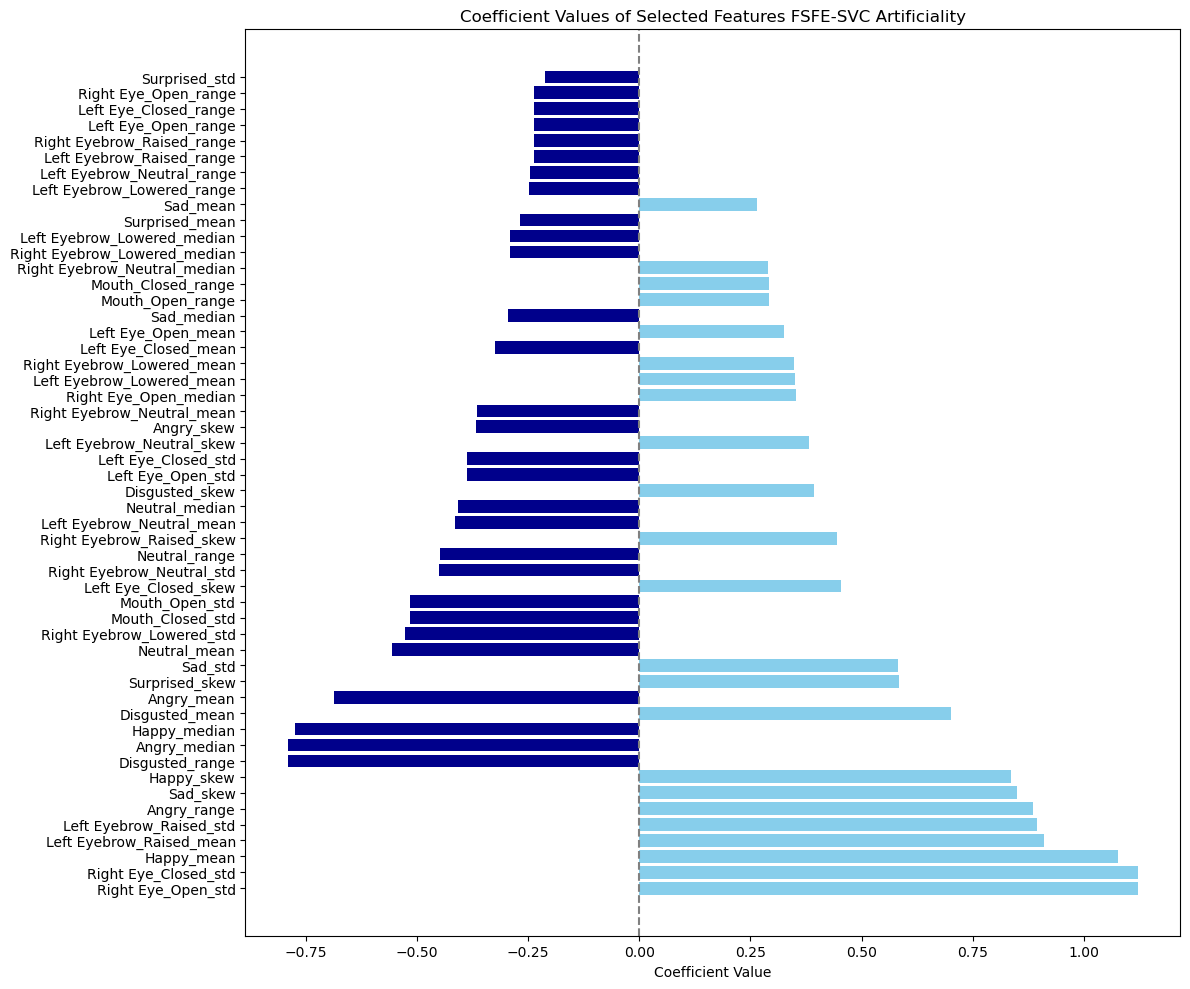

In [22]:
# Extract the boolean mask of selected features from RFECV
selected_features_mask_svc = best_pipeline_svc.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_svc = feature_names[selected_features_mask_svc]

# Extract the coefficients from the SVC model
coefficients_svc = best_pipeline_svc.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_svc = pd.DataFrame({
    'Feature': selected_feature_names_svc,
    'Coefficient': coefficients_svc
})

# Sort the DataFrame by the absolute values of the coefficients for better readability
features_coefficients_df_svc = features_coefficients_df_svc.reindex(
    features_coefficients_df_svc.Coefficient.abs().sort_values(ascending=False).index
)

# Output the table
print(features_coefficients_df_svc)

# Save the DataFrame to a CSV file
features_coefficients_df_svc.to_csv('FSFE_Artificiality_Feature_Coefficients_SVC.csv', index=False)

# Define colors based on the sign of the coefficients
colors = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_svc['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 10))
plt.barh(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Coefficient'],
    color=colors
)
plt.yticks(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FSFE-SVC Artificiality')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

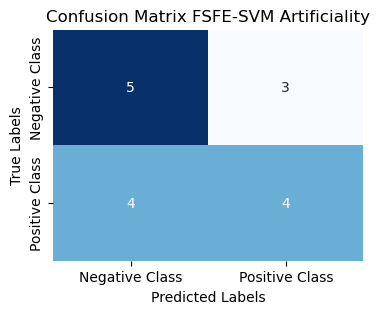

In [23]:
# Calculate the confusion matrix for the test data
cm_svc = confusion_matrix(y_test, y_test_pred_svc)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FSFE-SVM Artificiality')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()